In [2]:
import pandas as pd

In [4]:
import pandas as pd

df= pd.read_csv("../data/raw/ecommerce_clickstream_transactions.csv")
df.head()

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome
0,1,1,2024-07-07 18:00:26.959902,page_view,NaN,NaN,NaN
1,1,1,2024-03-05 22:01:00.072000,page_view,NaN,NaN,NaN
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,NaN
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,NaN
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74817 entries, 0 to 74816
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   UserID     74817 non-null  int64  
 1   SessionID  74817 non-null  int64  
 2   Timestamp  74817 non-null  object 
 3   EventType  74817 non-null  object 
 4   ProductID  32113 non-null  object 
 5   Amount     10682 non-null  float64
 6   Outcome    10682 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 4.0+ MB


In [6]:
df["EventType"].value_counts()

EventType
page_view       10819
add_to_cart     10735
product_view    10696
logout          10685
purchase        10682
click           10632
login           10568
Name: count, dtype: int64

In [7]:
# Filter funnel events only
funnel_events = df[df["EventType"].isin(["page_view", "product_view","add_to_cart", "purchase"])]
funnel_events.head()


,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome
0,1,1,2024-07-07 18:00:26.959902,page_view,NaN,NaN,NaN
1,1,1,2024-03-05 22:01:00.072000,page_view,NaN,NaN,NaN
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,NaN
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,NaN
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,NaN


In [8]:
funnel_events.shape

(42932, 7)

In [9]:
df = df.dropna(subset=["UserID"])

In [10]:
funnel_events.head()

,UserID,SessionID,Timestamp,EventType,ProductID,Amount,Outcome
0,1,1,2024-07-07 18:00:26.959902,page_view,NaN,NaN,NaN
1,1,1,2024-03-05 22:01:00.072000,page_view,NaN,NaN,NaN
2,1,1,2024-03-23 22:08:10.568453,product_view,prod_8199,NaN,NaN
3,1,1,2024-03-12 00:32:05.495638,add_to_cart,prod_4112,NaN,NaN
4,1,1,2024-02-25 22:43:01.318876,add_to_cart,prod_3354,NaN,NaN


In [11]:
funnel_events.shape

(42932, 7)

In [12]:
# One Funnel pass per UserID

funnel =(
    funnel_events
    .groupby("UserID")["EventType"]
    .unique()
    .reset_index()
)
# Create boolean indicator columns for each step in the funnel.
# Each column checks whether the EventType string contains a specific action.
# This allows us to track how users move through the funnel: 
# page_view → product_view → add_to_cart → purchase.
funnel.head()

,UserID,EventType
0,1,"[page_view, product_view, add_to_cart, purchase]"
1,2,"[page_view, purchase, add_to_cart, product_view]"
2,3,"[add_to_cart, purchase, page_view, product_view]"
3,4,"[purchase, page_view, add_to_cart, product_view]"
4,5,"[add_to_cart, page_view, product_view, purchase]"


In [13]:
# Create boolean indicator columns for each step in the funnel.
# Each column checks whether the EventType string contains a specific action.
# This allows us to track how users move through the funnel: 
# page_view → product_view → add_to_cart → purchase.


# Create a boolean column indicating whether the event is a page view
funnel['page_view'] = funnel['EventType'].apply(lambda x: 'page_view' in x)

# Create a boolean column indicating whether the event is a product view
funnel['product_view'] = funnel['EventType'].apply(lambda x: 'product_view' in x)

# Create a boolean column indicating whether the event is an add-to-cart action
funnel['add_to_cart'] = funnel['EventType'].apply(lambda x: 'add_to_cart' in x)

# Create a boolean column indicating whether the event is a purchase
funnel['purchase'] = funnel['EventType'].apply(lambda x: 'purchase' in x)

In [12]:
funnel.head()

,UserID,EventType,page_view,product_view,add_to_cart,purchase
0,1,"[page_view, product_view, add_to_cart, purchase]",True,True,True,True
1,2,"[page_view, purchase, add_to_cart, product_view]",True,True,True,True
2,3,"[add_to_cart, purchase, page_view, product_view]",True,True,True,True
3,4,"[purchase, page_view, add_to_cart, product_view]",True,True,True,True
4,5,"[add_to_cart, page_view, product_view, purchase]",True,True,True,True


In [15]:
# Create a summary table showing how many users reached each step of the funnel.
# Each value is calculated by summing the boolean indicator columns created earlier.
# This structure makes it easy to analyze drop-off between steps and calculate
# conversion rates throughout the customer journey.


funnel_counts = pd.DataFrame({
    
    # Names of the funnel steps in order
    'step': ['Page View', 'Product View', 'Add to Cart', 'Purchase'],
    
    # Count of users/events for each step, computed by summing the boolean columns
    'users': [
        funnel['page_view'].sum(),        # Total number of page views
        funnel['product_view'].sum(),     # Total number of product views
        funnel['add_to_cart'].sum(),      # Total number of add-to-cart events
        funnel['purchase'].sum()          # Total number of purchases
    ]
})

funnel_counts

,step,users
0,Page View,1000
1,Product View,1000
2,Add to Cart,1000
3,Purchase,1000


In [16]:
funnel_counts['conversion_rate'] = (
    funnel_counts['users'] / funnel_counts['users'].shift(1)
)

funnel_counts['drop_off_rate'] = 1 - funnel_counts['conversion_rate']
funnel_counts


,step,users,conversion_rate,drop_off_rate
0,Page View,1000,NaN,NaN
1,Product View,1000,1.0,0.0
2,Add to Cart,1000,1.0,0.0
3,Purchase,1000,1.0,0.0


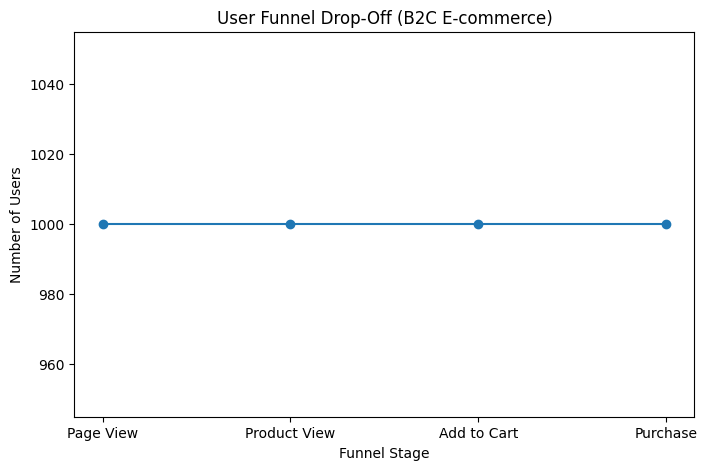

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(funnel_counts['step'], funnel_counts['users'], marker='o')
plt.title('User Funnel Drop-Off (B2C E-commerce)')
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Users')
plt.show()

In [18]:
df = df.sort_values(['UserID', 'Timestamp'])


In [ ]:
steps = ['page_view', 'product_view', 'add_to_cart', 'purchase']

user_steps = (
    df[df['EventType'].isin(steps)]
    .groupby(['UserID', 'EventType'])['Timestamp']
    .min()
    .unstack()
)


user_steps

EventType,add_to_cart,page_view,product_view,purchase
UserID,,,,
1,2024-01-02 00:15:51.420238,2024-01-01 23:09:51.956825,2024-01-13 19:09:28.166082,2024-01-19 16:51:29.413903
2,2024-01-01 14:07:40.491141,2024-01-25 23:29:19.998646,2024-02-01 13:04:02.540578,2024-01-07 08:29:00.313651
3,2024-01-28 23:19:16.739808,2024-02-14 10:49:22.406027,2024-01-28 04:05:50.814865,2024-01-23 18:04:26.951982
4,2024-01-18 16:10:27.101290,2024-01-01 02:11:06.298369,2024-01-28 09:19:43.994239,2024-02-04 10:29:30.492336
5,2024-01-29 10:06:50.111563,2024-01-05 11:02:48.872797,2024-01-01 14:03:07.709158,2024-01-15 09:52:49.801700
...,...,...,...,...
996,2024-01-01 08:53:50.704048,2024-01-23 02:57:29.945877,2024-03-07 12:34:26.451092,2024-01-04 10:54:46.088114
997,2024-02-13 01:09:40.145388,2024-01-09 07:41:11.913300,2024-01-08 10:34:41.716964,2024-01-10 17:53:58.821270
998,2024-01-01 01:32:21.757024,2024-01-01 22:24:17.901378,2024-01-04 22:19:30.074693,2024-01-07 12:23:48.987900


In [22]:
funnel_users = pd.DataFrame(index=user_steps.index)

funnel_users['page_view'] = user_steps['page_view'].notna()

funnel_users['product_view'] = (
    funnel_users['page_view'] &
    user_steps['product_view'].notna() &
    (user_steps['product_view'] > user_steps['page_view'])
)

funnel_users['add_to_cart'] = (
    funnel_users['product_view'] &
    user_steps['add_to_cart'].notna() &
    (user_steps['add_to_cart'] > user_steps['product_view'])
)

funnel_users['purchase'] = (
    funnel_users['add_to_cart'] &
    user_steps['purchase'].notna() &
    (user_steps['purchase'] > user_steps['add_to_cart'])
)

funnel_users

,page_view,product_view,add_to_cart,purchase
UserID,,,,
1,True,True,False,False
2,True,True,False,False
3,True,False,False,False
4,True,True,False,False
5,True,False,False,False
...,...,...,...,...
996,True,True,False,False
997,True,False,False,False
998,True,True,False,False


In [21]:
funnel_counts = pd.DataFrame({
    'step': ['Page View', 'Product View', 'Add to Cart', 'Purchase'],
    'users': [
        funnel_users['page_view'].sum(),
        funnel_users['product_view'].sum(),
        funnel_users['add_to_cart'].sum(),
        funnel_users['purchase'].sum()
    ]
})

funnel_counts['conversion_rate'] = (
    funnel_counts['users'] / funnel_counts['users'].shift(1)
)

funnel_counts['drop_off_rate'] = 1 - funnel_counts['conversion_rate']
funnel_counts


,step,users,conversion_rate,drop_off_rate
0,Page View,1000,NaN,NaN
1,Product View,494,0.494000,0.506000
2,Add to Cart,163,0.329960,0.670040
3,Purchase,41,0.251534,0.748466


## Funnel Insight
The largest drop-off occurs between Add to Cart and Purchase, where approximately 75% of users abandon before completing the transaction. This suggests checkout or payment-related friction and represents the highest-impact area for experimentation.
